<a href="https://colab.research.google.com/github/nctamer/PaganiniOp1/blob/main/alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown Import modules
!pip install numba==0.53    &> /dev/null
!pip install synctoolbox    &> /dev/null
!pip install libfmp    &> /dev/null
!git clone https://github.com/nctamer/PaganiniOp1.git   &> /dev/null
!pip install libf0   &> /dev/null
!pip install yt-dlp   &> /dev/null
import pretty_midi
from IPython.display import YouTubeVideo
import librosa
import IPython.display as ipd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
import random
import numpy as np
import librosa
from librosa.sequence import viterbi_discriminative
import sys, math
import glob
import time
import numpy as np
import matplotlib.image as mpimg
from tqdm import tqdm
from pathlib import Path
import os
from scipy.stats import norm
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import libf0

def split_name(name):
    player, rest = name.rsplit('_[',1)
    key, rest = rest.split(']_', 1)
    dur = int(rest[:4])
    return player, key, dur
f0_dir = 'PaganiniOp1/pitch/finetuned_instrument_model_100_005'
f0s = [os.path.relpath(_, f0_dir) for _ in sorted(glob.glob(os.path.join(f0_dir,'*','*.csv')))]
df = pd.DataFrame(f0s, columns=['f0Path'])
df = df.join(df['f0Path'].str.split('/',expand=True))
df.columns = ['f0Path', 'No', 'rest']
df = df.join(pd.DataFrame(df['rest'].apply(split_name).to_list(), columns=['PlayerID', 'YouTubeKey', 'Duration']))
del df['rest']
print('Total duration:', df.Duration.sum() / 3600, 'hours')

Total duration: 9.391388888888889 hours


# Alignment for the 9 hours 23 minutes of Paganini caprices!



Anchor points are generated from CREPE trained on the Violin Etudes with two stage confidence filtering and matching the start and end notes with the midi content. 


1.   First we run a median filter with kernel size 9 to obtain a smooth version of confidences. This is used in removing noise, we use a confidence threshold of 0.5 for the smooth version.
2.   Then another (more strict) confidence is used to remove the noise further for that specific instant (0.9)
3.   Then we match the start and end MIDI content to these pitch estimates, and only accept them if they match with the MIDI content.



We also have Basic Pitch (Spotify) estimates for these files. Not yet used! (though the precision is lower)

TODO:
1.   Benchmark Basic Pitch 
2.   PaganiniOp1/audio/No24/InmoYang_XSkvIuiHIAI has applause!


In [2]:
#@markdown write score_informed_pitch_detection.py 
%%writefile score_informed_pitch_detection.py
import numpy as np
from scipy import linalg
import libfmp.c8
from matplotlib import pyplot as plt
import matplotlib


def hz_to_cents(F, F_ref=55.0):
    """Converts frequency in Hz to cents

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F (float or np.ndarray): Frequency value in Hz
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F_cent (float or np.ndarray): Frequency in cents
    """
    F_cent = 1200 * np.log2(F / F_ref)
    return F_cent

def cents_to_hz(F_cent, F_ref=55.0):
    """Converts frequency in cents to Hz

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F_cent (float or np.ndarray): Frequency in cents
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F (float or np.ndarray): Frequency in Hz
    """
    F = F_ref * 2 ** (F_cent / 1200)
    return F


def define_transition_matrix(B, tol=0, score_low=0.01, score_high=1.0):
    """Generate transition matrix

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        B (int): Number of bins
        tol (int): Tolerance parameter for transition matrix (Default value = 0)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        T (np.ndarray): Transition matrix
    """
    col = np.ones((B,)) * score_low
    col[0:tol+1] = np.ones((tol+1, )) * score_high
    T = linalg.toeplitz(col)
    return T

def convert_ann_to_constraint_region(ann, tol_freq_cents=300.0):
    """Convert score annotations to constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        ann (list): Score annotations [[start_time, end_time, MIDI_pitch], ...
        tol_freq_cents (float): Tolerance in pitch directions specified in cents (Default value = 300.0)

    Returns:
        constraint_region (np.ndarray): Constraint regions
    """
    tol_pitch = tol_freq_cents / 100
    freq_lower = 2 ** ((ann[:, 2] - tol_pitch - 69)/12) * 440
    freq_upper = 2 ** ((ann[:, 2] + tol_pitch - 69)/12) * 440
    constraint_region = np.concatenate((ann[:, 0:2],
                                        freq_lower.reshape(-1, 1),
                                        freq_upper.reshape(-1, 1)), axis=1)
    return constraint_region


def compute_trajectory_dp(Z, T):
    """Trajectory tracking using dynamic programming

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T: Transisition matrix

    Returns:
        eta_DP (np.ndarray): Trajectory indices
    """
    B, N = Z.shape
    eps_machine = np.finfo(np.float32).eps
    Z_log = np.log(Z + eps_machine)
    T_log = np.log(T + eps_machine)

    E = np.zeros((B, N))
    D = np.zeros((B, N))
    D[:, 0] = Z_log[:, 0]

    for n in np.arange(1, N):
        for b in np.arange(0, B):
            D[b, n] = np.max(T_log[b, :] + D[:, n-1]) + Z_log[b, n]
            E[b, n-1] = np.argmax(T_log[b, :] + D[:, n-1])

    # backtracking
    eta_DP = np.zeros(N)
    eta_DP[N-1] = int(np.argmax(D[:, N-1]))

    for n in np.arange(N-2, -1, -1):
        eta_DP[n] = E[int(eta_DP[n+1]), n]

    return eta_DP.astype(np.int64)


def compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region=None,
                          tol=5, score_low=0.01, score_high=1.0):
    """Trajectory tracking with constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z (np.ndarray): Salience representation
        T_coef (np.ndarray): Time axis
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        constraint_region (np.ndarray): Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end_hz)
            (Default value = None)
        tol (int): Tolerance parameter for transition matrix (Default value = 5)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        eta (np.ndarray): Trajectory indices, unvoiced frames are indicated with -1
    """
    # do tracking within every constraint region
    if constraint_region is not None:
        # initialize contour, unvoiced frames are indicated with -1
        eta = np.full(len(T_coef), -1)

        for row_idx in range(constraint_region.shape[0]):
            t_start = constraint_region[row_idx, 0]  # sec
            t_end = constraint_region[row_idx, 1]  # sec
            f_start = constraint_region[row_idx, 2]  # Hz
            f_end = constraint_region[row_idx, 3]  # Hz

            # convert start/end values to indices
            t_start_idx = np.argmin(np.abs(T_coef - t_start))
            t_end_idx = np.argmin(np.abs(T_coef - t_end))
            f_start_idx = np.argmin(np.abs(F_coef_hertz - f_start))
            f_end_idx = np.argmin(np.abs(F_coef_hertz - f_end))

            # track in salience part
            cur_Z = Z[f_start_idx:f_end_idx+1, t_start_idx:t_end_idx+1]
            T = define_transition_matrix(cur_Z.shape[0], tol=tol,
                                         score_low=score_low, score_high=score_high)
            cur_eta = compute_trajectory_dp(cur_Z, T)

            # fill contour
            eta[t_start_idx:t_end_idx+1] = f_start_idx + cur_eta
    else:
        T = define_transition_matrix(Z.shape[0], tol=tol, score_low=score_low, score_high=score_high)
        eta = compute_trajectory_dp(Z, T)

    return eta


def compute_traj_from_audio(x, Fs=22050, N=1024, H=128, R=10.0, F_min=55.0, F_max=1760.0,
                            num_harm=10, freq_smooth_len=11, alpha=0.9, gamma=0.0,
                            constraint_region=None, tol=5, score_low=0.01, score_high=1.0):
    """Compute F0 contour from audio signal

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling frequency (Default value = 22050)
        N (int): Window length in samples (Default value = 1024)
        H (int): Hopsize in samples (Default value = 128)
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (Default value = 1760.0)
        num_harm (int): Number of harmonics (Default value = 10)
        freq_smooth_len (int): Filter length for vertical smoothing (Default value = 11)
        alpha (float): Weighting parameter for harmonics (Default value = 0.9)
        gamma (float): Logarithmic compression factor (Default value = 0.0)
        constraint_region (np.ndarray): Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end,hz)
            (Default value = None)
        tol (int): Tolerance parameter for transition matrix (Default value = 5)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        traj (np.ndarray): F0 contour, time in seconds in 1st column, frequency in Hz in 2nd column
        Z (np.ndarray): Salience representation
        T_coef (np.ndarray): Time axis
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    Z, F_coef_hertz, F_coef_cents = libfmp.c8.compute_salience_rep(
        x, Fs, N=N, H=H, R=R, F_min=F_min, F_max=F_max, num_harm=num_harm, freq_smooth_len=freq_smooth_len,
        alpha=alpha, gamma=gamma)

    T_coef = (np.arange(Z.shape[1]) * H) / Fs
    index_CR = compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region,
                                     tol=tol, score_low=score_low, score_high=score_high)

    traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_CR].reshape(-1, 1)))
    traj[index_CR == -1, 1] = 0
    return traj, Z, T_coef, F_coef_hertz, F_coef_cents


def visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=55.0, colorbar=True, cmap='gray_r',
                                        figsize=(7, 4), traj=None, constraint_region=None, ax=None):
    """Visualize salience representation with optional F0-trajectory and constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T_coef: Time axis
        F_coef_cents: Frequency axis in cents
        F_ref: Reference frequency (Default value = 55.0)
        colorbar: Show or hide colorbar (Default value = True)
        cmap: Color map (Default value = 'gray_r')
        figsize: Figure size (Default value = (7, 4))
        traj: F0 trajectory (time in seconds, frequency in Hz) (Default value = None)
        constraint_region: Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end,hz)
            (Default value = None)
        ax: Handle to existing axis (Default value = None)

    Returns:
        fig: Handle to figure
        ax: Handle to cent axis
        ax_f: Handle to frequency axis
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    sal = ax.imshow(Z, extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]],
                    cmap=cmap, origin='lower', aspect='auto', interpolation='nearest')

    y_ticklabels_left = np.arange(F_coef_cents[0], F_coef_cents[-1]+1, 1200)
    ax.set_yticks(y_ticklabels_left)
    ax.set_yticklabels(y_ticklabels_left)
    ax.set_ylabel('Frequency (Cents)')

    if colorbar:
        plt.colorbar(sal, ax=ax, pad=0.1)

    ax_f = ax.twinx()  # instantiate a second axes that shares the same y-axis
    ax_f.set_yticks(y_ticklabels_left - F_coef_cents[0])
    y_ticklabels_right = cents_to_hz(y_ticklabels_left, F_ref).astype(int)
    ax_f.set_yticklabels(y_ticklabels_right)
    ax_f.set_ylabel('Frequency (Hz)')

    # plot contour
    if traj is not None:
        traj_plot = traj[traj[:, 1] > 0, :]
        traj_plot[:, 1] = hz_to_cents(traj_plot[:, 1], F_ref)
        ax.plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='')

    # plot constraint regions
    if constraint_region is not None:
        for row in constraint_region:
            t_start = row[0]  # sec
            t_end = row[1]  # sec
            f_start = row[2]  # Hz
            f_end = row[3]  # Hz
            ax.add_patch(matplotlib.patches.Rectangle((
                t_start, hz_to_cents(f_start, F_ref)), width=t_end-t_start,
                height=hz_to_cents(f_end, F_ref)-hz_to_cents(f_start, F_ref),
                fill=False, edgecolor='k', linewidth=3, zorder=2))

    ax.set_xlabel('Time (seconds)')

    if fig is not None:
        plt.tight_layout()

    return fig, ax, ax_f

Writing score_informed_pitch_detection.py


In [57]:
#@markdown Alignment code

import os.path
from libfmp.b import list_to_pitch_activations, plot_chromagram, plot_signal, plot_matrix, \
                     sonify_pitch_activations_with_signal
from libfmp.b import plot_chromagram
import libfmp.c2
from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw, sync_via_mrmsdtw_with_anchors
from synctoolbox.dtw.utils import compute_optimal_chroma_shift, shift_chroma_vectors, make_path_strictly_monotonic
from synctoolbox.feature.csv_tools import read_csv_to_df, df_to_pitch_features, df_to_pitch_onset_features
from synctoolbox.feature.chroma import pitch_to_chroma, quantize_chroma, quantized_chroma_to_CENS
from synctoolbox.feature.pitch import audio_to_pitch_features
from synctoolbox.feature.utils import estimate_tuning
import pandas as pd
import numpy as np
import librosa
import librosa.effects
import glob
import copy
from score_informed_pitch_detection import convert_ann_to_constraint_region, visualize_salience_traj_constraints, cents_to_hz, hz_to_cents
import matplotlib.pyplot as plt
import librosa.display
import libf0
from scipy.signal import medfilt


Fs = 22050
H = 128
feature_rate = 150
step_weights = np.array([1.5, 1.5, 2.0])
threshold_rec = 10 ** 6

def get_features_from_audio(audio, tuning_offset, visualize=False):  # TODO could make this part of a module
    f_pitch = audio_to_pitch_features(f_audio=audio, Fs=Fs, tuning_offset=tuning_offset, feature_rate=feature_rate,
                                      verbose=visualize)
    f_chroma = pitch_to_chroma(f_pitch=f_pitch)
    f_chroma_quantized = quantize_chroma(f_chroma=f_chroma)
    return f_chroma_quantized


def get_features_from_annotation(df_annotation):
    f_pitch = df_to_pitch_features(df_annotation, feature_rate=feature_rate)
    f_chroma = pitch_to_chroma(f_pitch=f_pitch)
    f_chroma_quantized = quantize_chroma(f_chroma=f_chroma)
    return f_chroma_quantized

def get_corresponding_audio_frame(ann_audio_wp, ann_index, end=False):
    pair = ann_audio_wp[:, ann_audio_wp[0]==ann_index]
    if end:
        return pair[1,-1]
    else:
        return pair[1,0]

def midi2df(midi_file):
      midi_data = pretty_midi.PrettyMIDI(midi_file)
      midi_list = []

      for instrument in midi_data.instruments:
          for note in instrument.notes:
              start = note.start
              end = note.end
              duration = end - start
              pitch = note.pitch
              velocity = note.velocity / 128
              midi_list.append([start, duration, pitch, velocity, 'violin'])

      midi_list = sorted(midi_list, key=lambda x: (x[0], x[2]))

      df = pd.DataFrame(midi_list, columns=['start', 'duration', 'pitch', 'velocity', 'instrument'])
      return df

def deter_anchors_from_f0_and_midi(f0_content, df_ann, f0_threshold):
    smoothened_confidences = medfilt(f0_content.confidence, kernel_size=15)
    anchor_candidates = f0_content[np.logical_and(f0_content.confidence>0.8,
                                                  smoothened_confidences>0.6)]

    # now start searching for an end anchor candidate in the last 100 rows
    end_anchor_candidates = anchor_candidates.iloc[-100:]
    end = end_anchor_candidates.time.iloc[0]

    # search pitch track for the last note events
    end_freqs = df_ann[df_ann.end==df_ann.end.max()].pitch.apply(pretty_midi.note_number_to_hz).values
    end_cents = np.tile(hz_to_cents(end_freqs), (2,1))
    end_cents[0, :] = end_cents[0, :] - 50  # lower bound
    end_cents[1, :] = end_cents[1, :] + 50  # upper bound
    end_freqs = cents_to_hz(end_cents)

    for i in range(end_freqs.shape[1]):
        end_min = end_freqs[0, i]
        end_max = end_freqs[1, i]
        is_cand = end_anchor_candidates.frequency.between(end_min, end_max)
        if is_cand.any():
          cand = end_anchor_candidates[is_cand].iloc[-1].time
          if cand > end:
              end = cand
              

    # now the same for the first 100 rows
    start_anchor_candidates = anchor_candidates.iloc[:100]
    start = start_anchor_candidates.time.iloc[-1]

    # search within the first midi event
    start_freqs = df_ann[df_ann.start==df_ann.start.min()].pitch.apply(pretty_midi.note_number_to_hz).values
    start_cents = np.tile(hz_to_cents(start_freqs), (2,1))
    start_cents[0, :] = start_cents[0, :] - 50
    start_cents[1, :] = start_cents[1, :] + 50
    start_freqs = cents_to_hz(start_cents)

    for i in range(start_freqs.shape[1]):
        start_min = start_freqs[0, i]
        start_max = start_freqs[1, i]
        is_cand = start_anchor_candidates.frequency.between(start_min, start_max)
        if is_cand.any():
          cand = start_anchor_candidates[is_cand].iloc[0].time
          if cand < start:
              start = cand
    return start, end

def midi2df_with_order(midi_file):
      midi_data = pretty_midi.PrettyMIDI(midi_file)
      midi_list = []

      for instrument in midi_data.instruments:
          for note in instrument.notes:
              start = note.start
              end = note.end
              duration = end - start
              pitch = note.pitch
              velocity = note.velocity / 128
              midi_list.append([start, duration, pitch, velocity, 'violin'])

      sort_index, midi_list = zip(*[(i, x) for i, x in sorted(enumerate(midi_list), key=lambda x: (x[1][0], x[1][2]))])

      df = pd.DataFrame(midi_list, columns=['start', 'duration', 'pitch', 'velocity', 'instrument'])
      return df, list(sort_index)

def aligned2midi_with_order(aligned_df, midi_file, note_order):
      midi_data = pretty_midi.PrettyMIDI(midi_file)
      new_midi = pretty_midi.PrettyMIDI()
      i = 0
      violin_program = pretty_midi.instrument_name_to_program('Violin')
      violin = pretty_midi.Instrument(program=violin_program)
      for instrument in midi_data.instruments:
          for note in instrument.notes:
              df_index = note_order[i]
              note.start = aligned_df.loc[df_index, 'start']
              note.end = aligned_df.loc[df_index, 'end']
              violin.notes.append(note)
              i += 1
      new_midi.instruments.append(violin)
      return new_midi

def aligned2midi(aligned_df, midi_file):
      midi_data = pretty_midi.PrettyMIDI(midi_file)
      new_midi = pretty_midi.PrettyMIDI()
      violin_program = pretty_midi.instrument_name_to_program('Violin')
      violin = pretty_midi.Instrument(program=violin_program)
      
      for i, row in aligned_df.iterrows():
          note = pretty_midi.Note(
              velocity=int(round(128*row.velocity)), 
              pitch=row.pitch, 
              start=row.start, 
              end=row.end)
          violin.notes.append(note)
      new_midi.instruments.append(violin)
      return new_midi

def align_midi(midi_path, audio_path, f0_path=None, offset=0, duration=None, debug=False, f0_threshold=0.5):
    # load annotation & get features (as it gets the chroma features of the annotation, I don't feel necessary to convert the MIDI notes to Hz)
    df_ann = midi2df(midi_path)  # MIDI info
    #df_ann, note_order = midi2df_with_order(midi_path)
    df_ann['start'] += 0.1
    df_ann['end'] = df_ann['start'] + df_ann['duration']
    f_ch_ann = get_features_from_annotation(df_ann)
    f_ch_ann = np.pad(f_ch_ann, ((0, 0), (0, int(np.ceil(0.1*feature_rate)))), 'constant') # GIMMICK! zero pad the end

    audio_recording, _ = librosa.load(audio_path, Fs, offset=offset, duration=duration)
    if f0_path:
        f0_content = pd.read_csv(f0_path)
        audio_start, audio_end = deter_anchors_from_f0_and_midi(f0_content, df_ann, f0_threshold=f0_threshold)
    else:  # then deter anchors from silences
        _, start_end_indices = librosa.effects.trim(audio_recording)
        audio_start = max(start_end_indices[0]/Fs, 10*feature_rate/Fs)   # start and end from librosa effects trim
        audio_end = min(start_end_indices[1]/Fs, len(audio_recording)/Fs) # we can also use f0 csv file
    f_ch_recording = get_features_from_audio(audio_recording, estimate_tuning(audio_recording, Fs))
    
    wp = sync_via_mrmsdtw_with_anchors(f_chroma1=f_ch_ann,
                                       f_chroma2=f_ch_recording,
                                       input_feature_rate=feature_rate,
                                       step_weights=step_weights,
                                       threshold_rec=threshold_rec,
                                       verbose=False,
                                       anchor_pairs=[(0.1, audio_start), (df_ann['end'].max(), audio_end)])
    
    # wp_mono = make_path_strictly_monotonic(wp) this is not improving anything
    df_aligned = copy.deepcopy(df_ann)
    for index, annotation in df_ann.iterrows():
        try:
            start = get_corresponding_audio_frame(wp, int(feature_rate*annotation.start))
            end = get_corresponding_audio_frame(wp, int(feature_rate*annotation.end), end=True)
            df_aligned.loc[index, 'start'] = start/feature_rate
            df_aligned.loc[index, 'end'] = end/feature_rate
            df_aligned.loc[index, 'duration'] = (end-start)/feature_rate
        except IndexError:
            print('error in', index, audio_path)


    if debug:
        # Visualization
        figsize = (25, 5)
        cmap = libfmp.b.compressed_gray_cmap(alpha=5)

        ann_score = df_aligned[['start', 'end', 'pitch']].values
        constraint_region = convert_ann_to_constraint_region(ann_score, tol_freq_cents=100)

        # SWIPE BELOW (but it is much worse)
        if not f0_path:
            # Plot the f0s together with the constraint region
            # shared parameters
            N = 2048 # window size in samples
            H = 256 # hop size in samples
            zero_pad = 2048 # zero-padding for STFT (only for visualization)
            F_min = 55.0 # minimum frequency of interest in Hz
            F_max = 1760.0 # maximum frequency of interest in Hz
            R = 10 # resolution of F0-estimations in cents
            # set parameters
            threshold = 0.2 # confidence threshold between 0 and 1
            x, _ = librosa.load(audio_path, sr=Fs)

            # run the SWIPE algorithm
            f0_swipe, t_swipe, conf_swipe = libf0.swipe(x, Fs, H, F_min, F_max, strength_threshold=threshold)
            f0_content = pd.DataFrame({'time': t_swipe, 'frequency':f0_swipe})
        else:
            #f0_content = pd.read_csv(f0_path, index_col=None, names=["time", "f"], header=None)
            f0_content.frequency = f0_content.frequency[f0_content.confidence>f0_threshold]

        T_coef = f0_content.time.values
        F_min, F_max = constraint_region[:, 2:].min(), constraint_region[:, 2:].max()

        F_coef_cents = np.arange(hz_to_cents(F_min)-10, hz_to_cents(F_max)+10, 10)
        Z = np.zeros((len(F_coef_cents), len(T_coef)))  # gimmick! we can use the stft instead. this is empty!!

        traj = f0_content[['time', 'frequency']].values

        # Visualization
        visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=cents_to_hz(F_coef_cents[0]), figsize=figsize, cmap=cmap,
                                            constraint_region=constraint_region, colorbar=False, traj=traj, ax=None)
        plt.title(audio_path)
        plt.show()

    return aligned2midi(df_aligned, midi_path)


PaganiniOp1/audio/No24/AlicanSuner_R7fLO3egvwM downloaded
........................................................................................

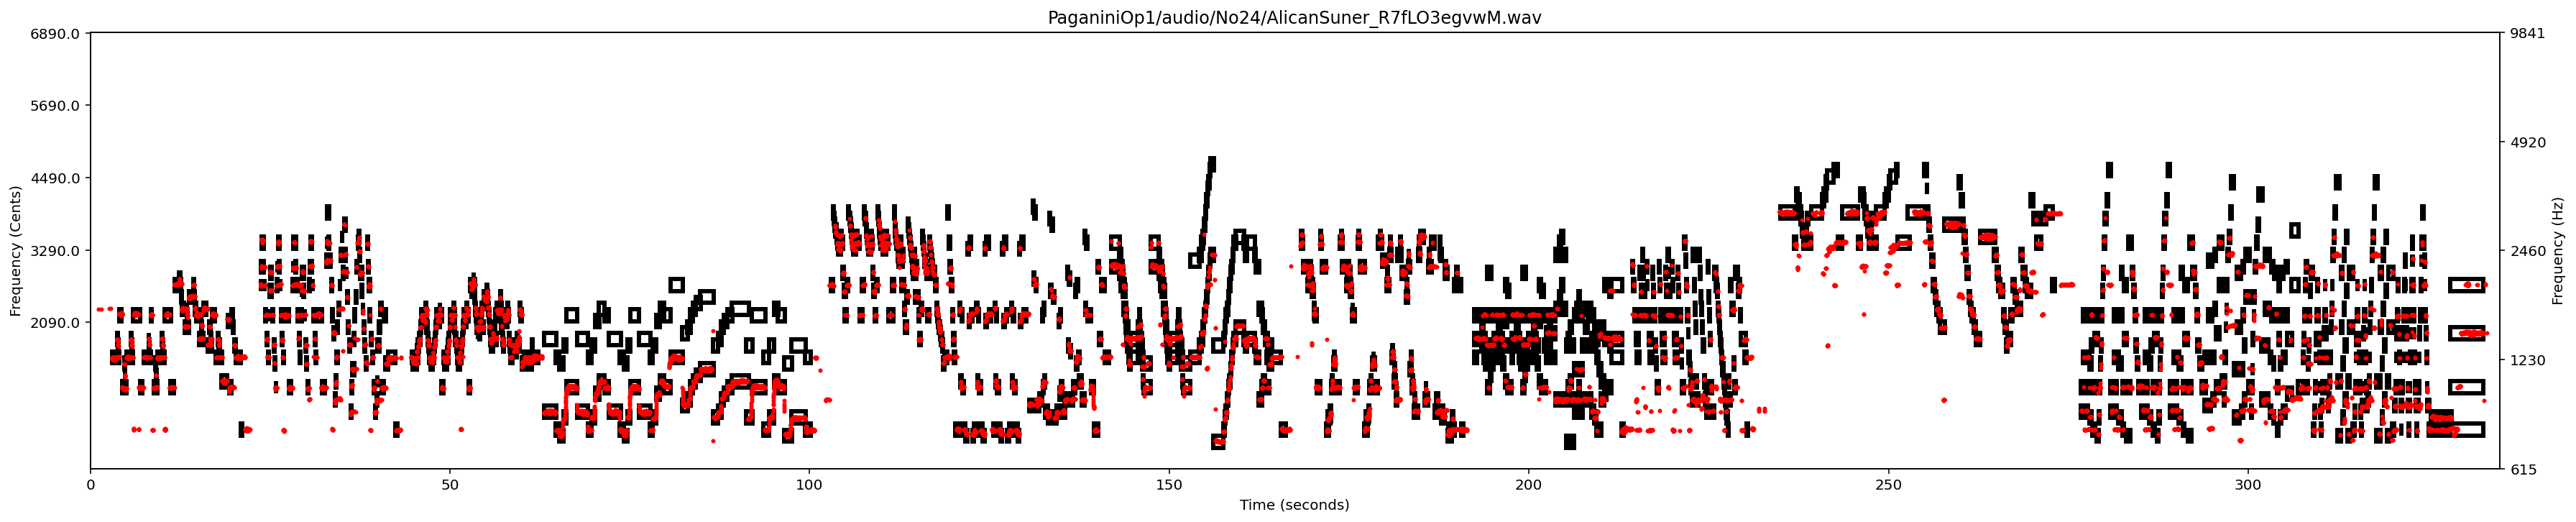

PaganiniOp1/audio/No24/AntalZalai_7WXlF5J-cFU downloaded
........................................................................................

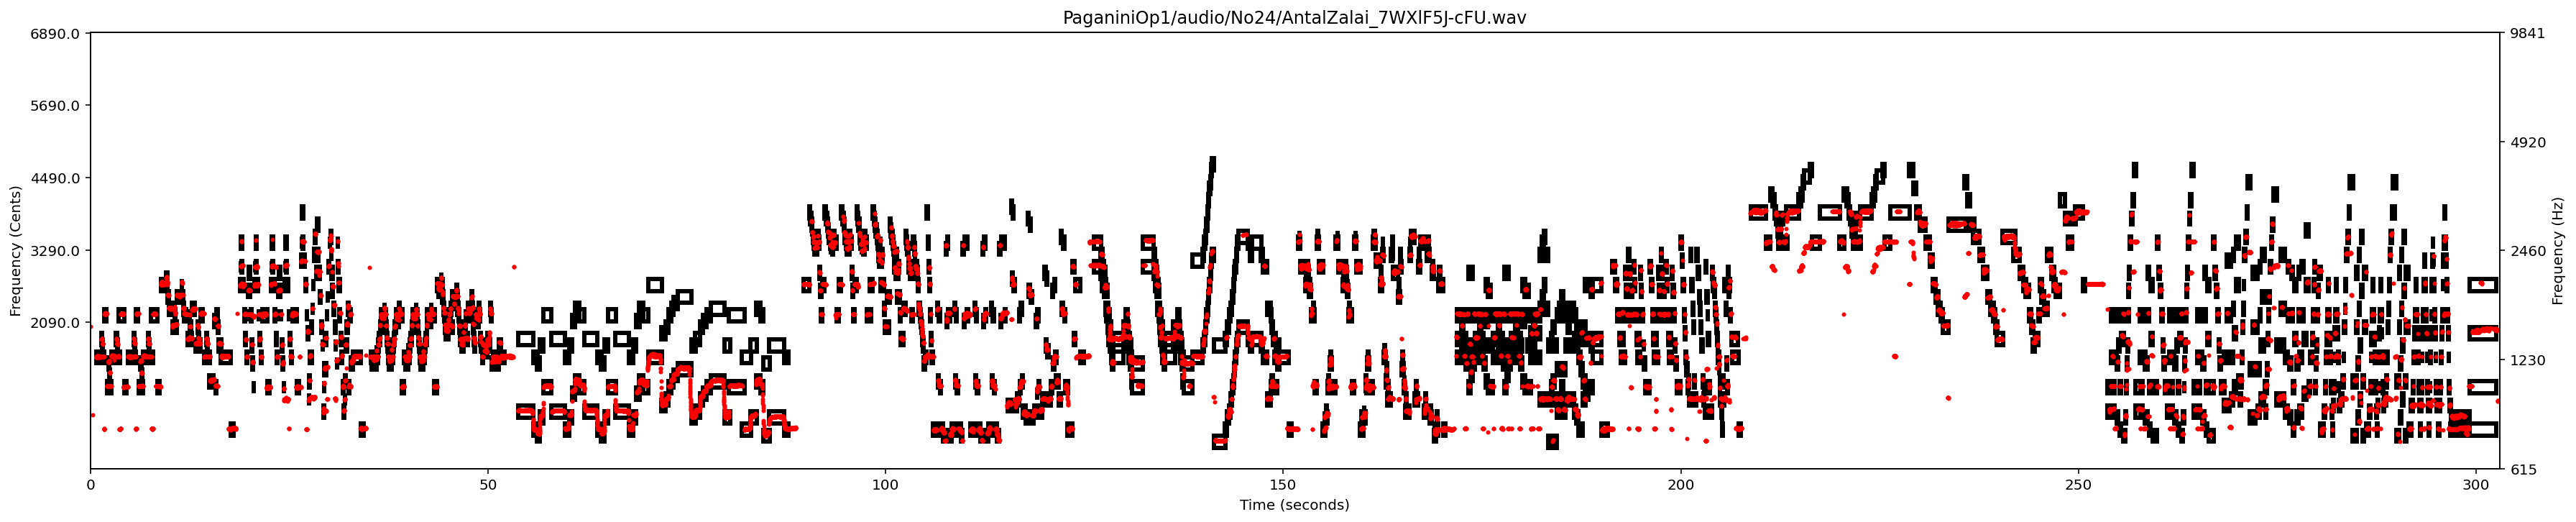

PaganiniOp1/audio/No24/IlyaKaler_JnXIXZLkn6M downloaded
........................................................................................

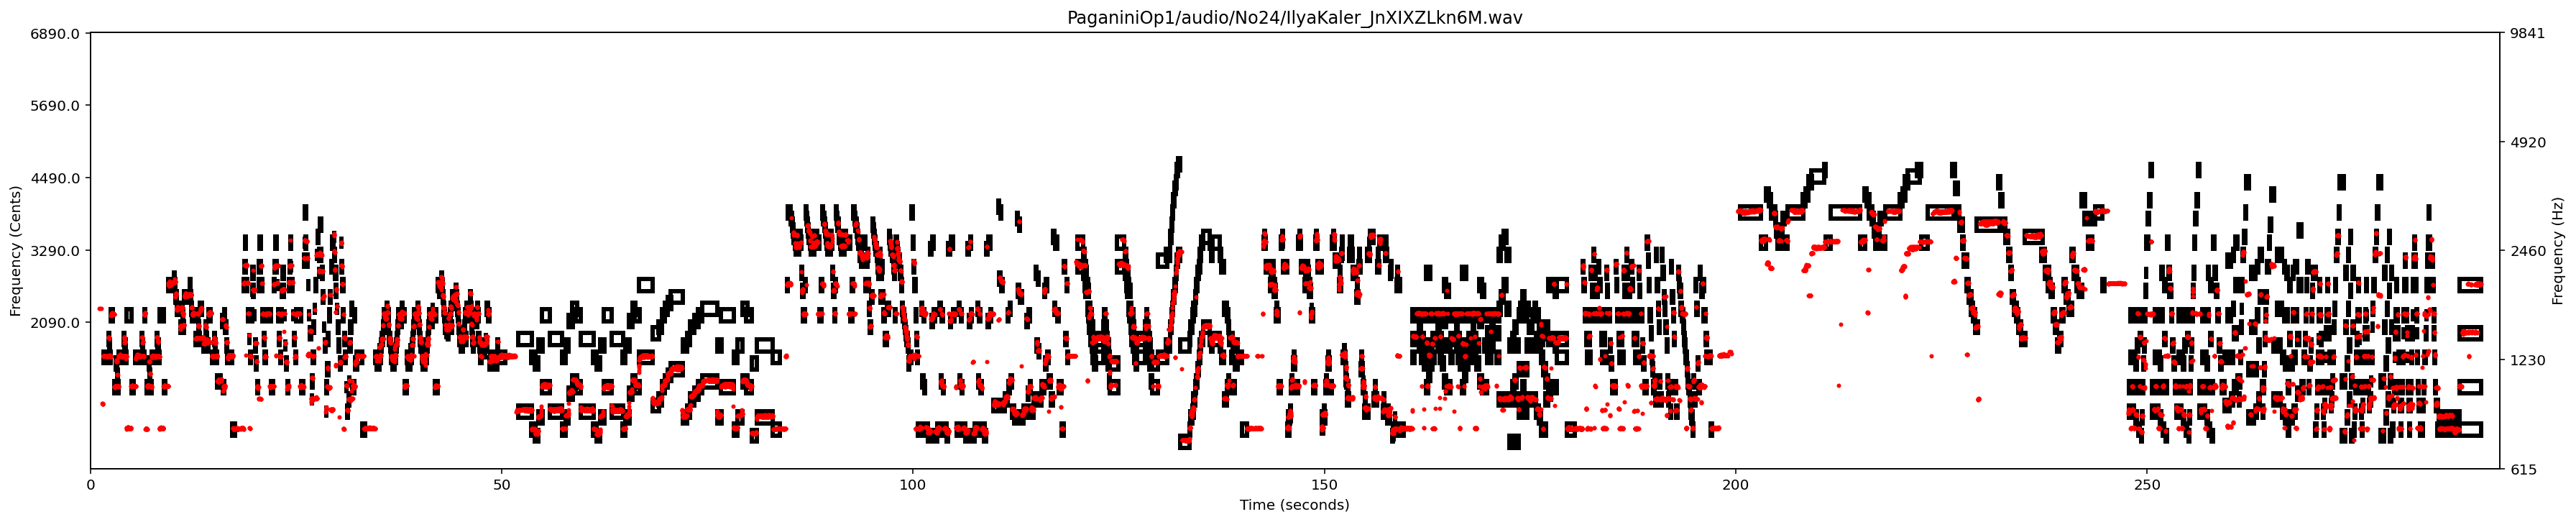

PaganiniOp1/audio/No24/InmoYang_XSkvIuiHIAI downloaded
........................................................................................

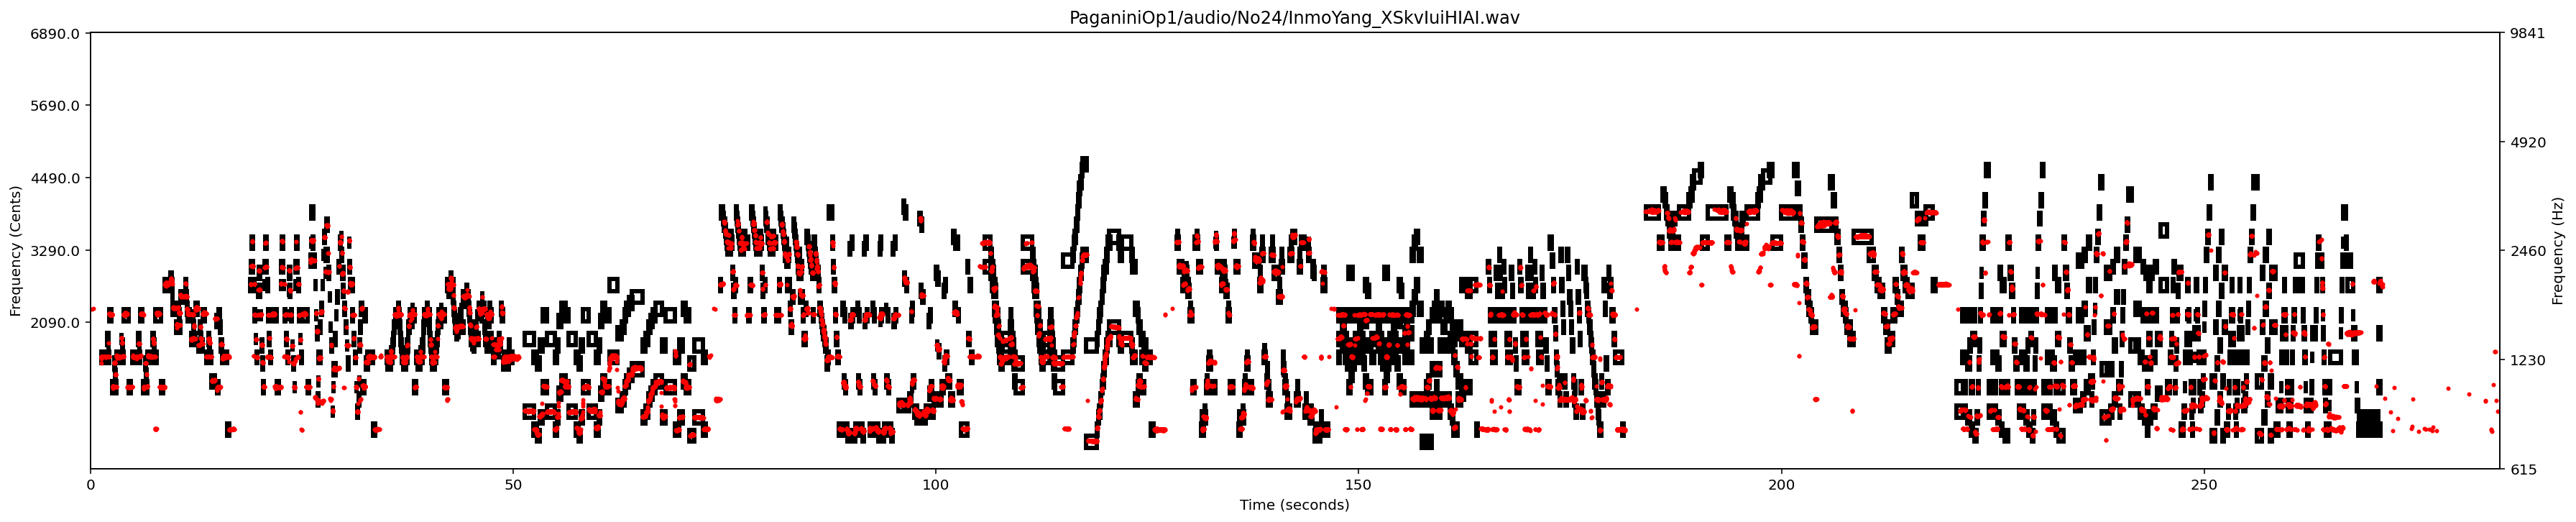

PaganiniOp1/audio/No24/ItzhakPerlman_r0m21rGZXx8 downloaded
........................................................................................

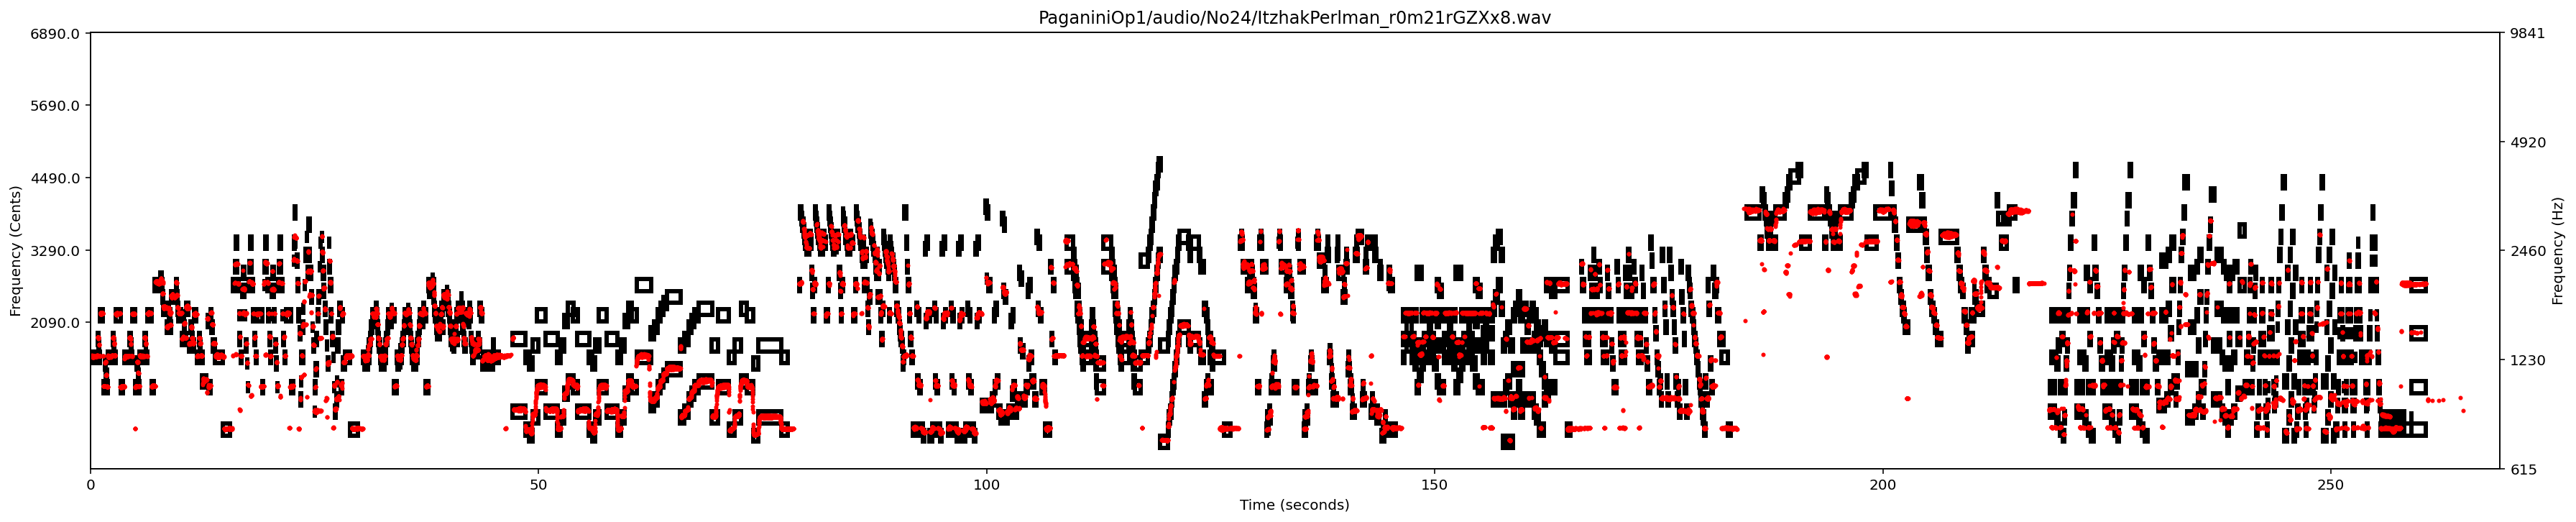

PaganiniOp1/audio/No24/JuliaFischer_bS9cn5NnsQA downloaded


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


ERROR IN PaganiniOp1/audio/No24/JuliaFischer_bS9cn5NnsQA
SKIPPING
PaganiniOp1/audio/No24/SalvatoreAccardo_uALsg4aWKB0 downloaded
........................................................................................

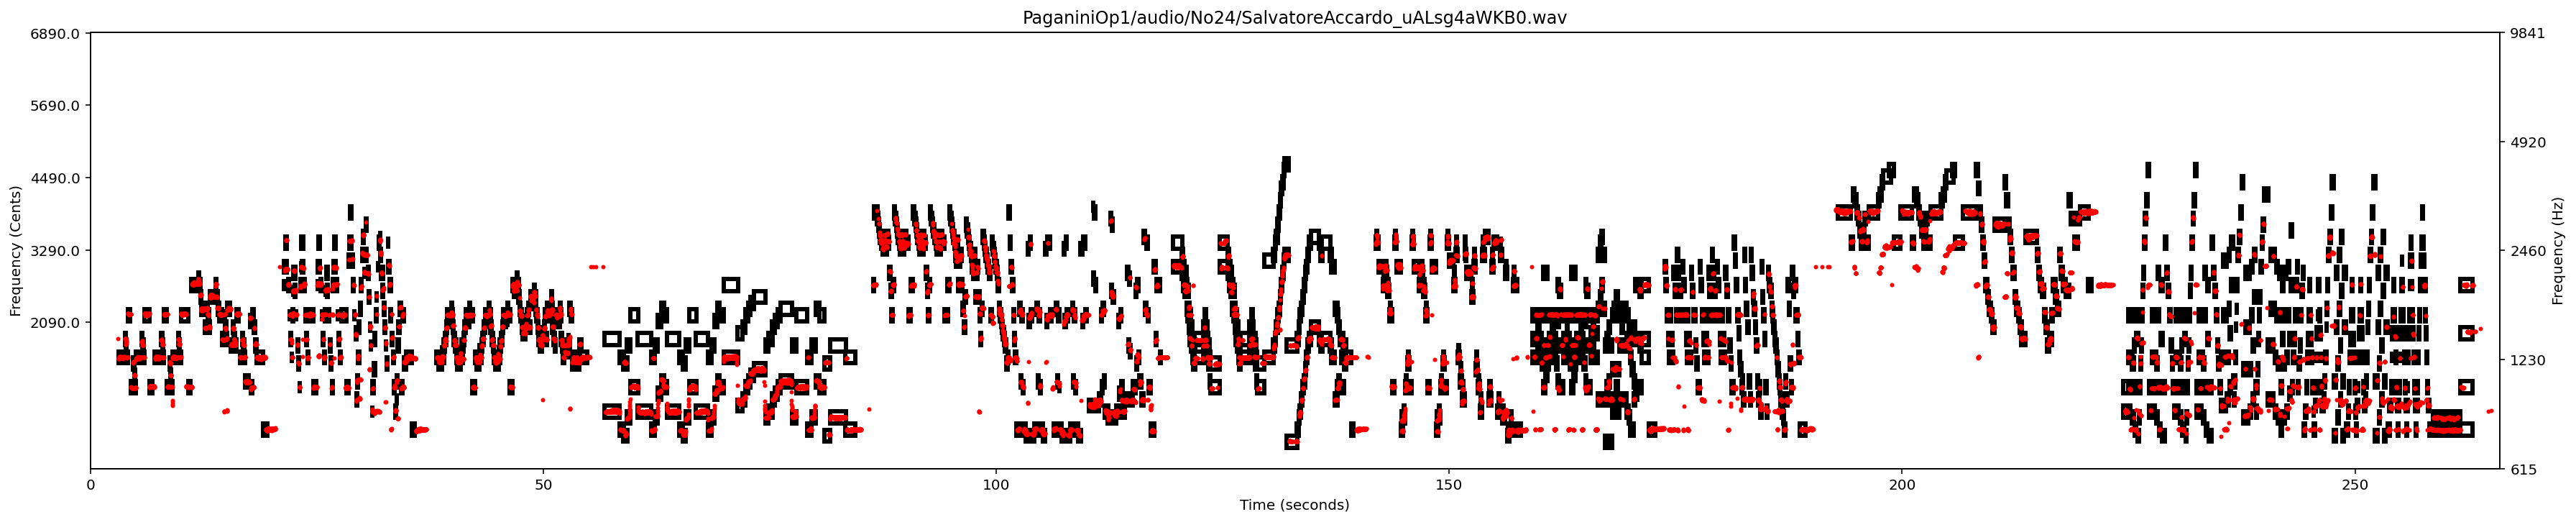

PaganiniOp1/audio/No01/AlicanSuner_lTsRFEpD6Jg downloaded
........................................................................................

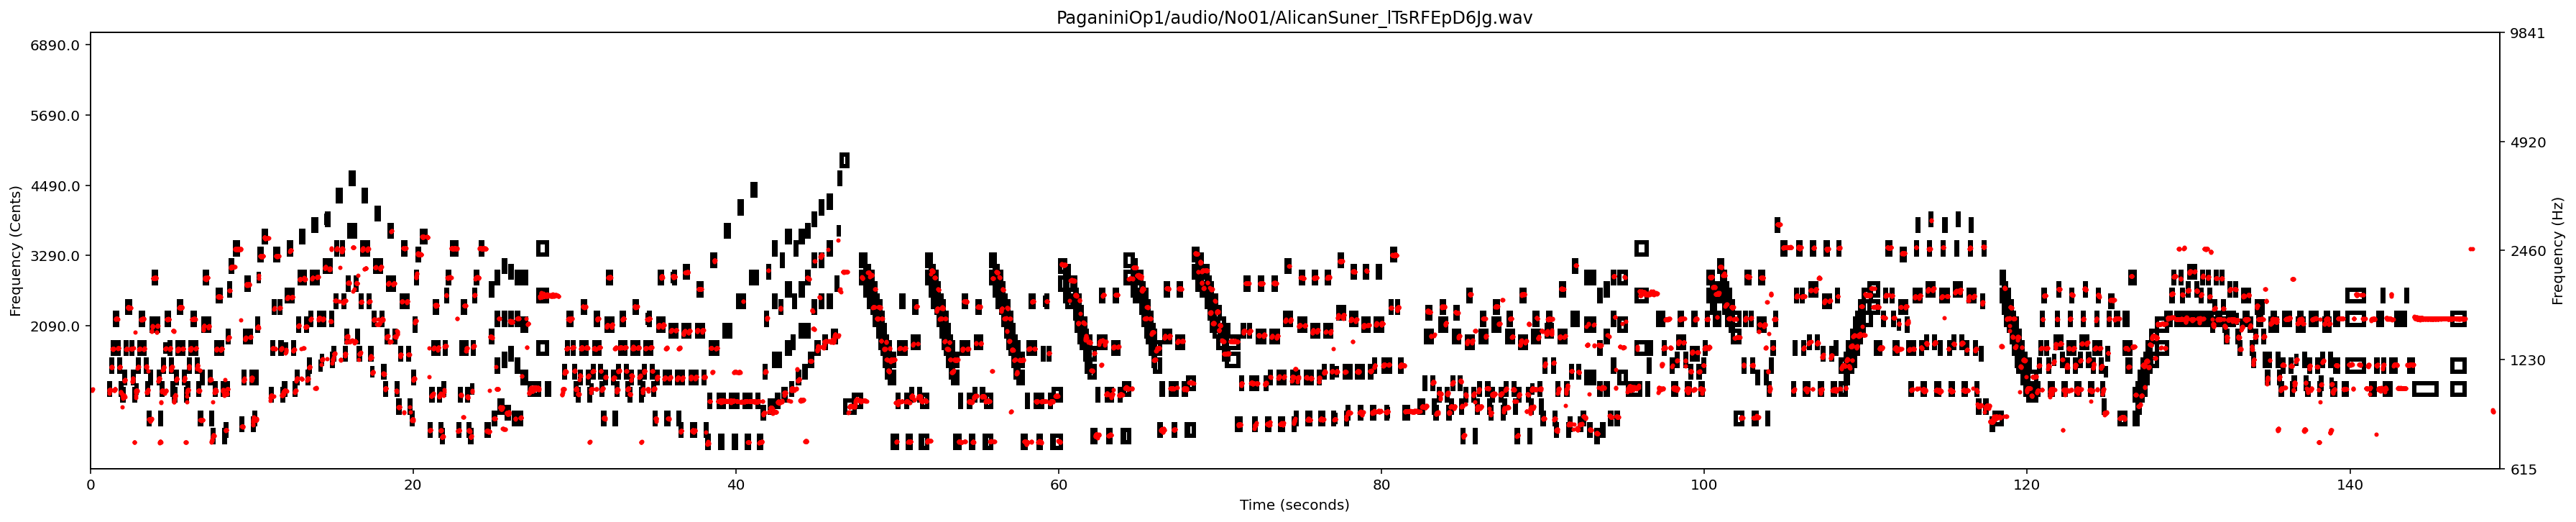

PaganiniOp1/audio/No01/AntalZalai_lrrPSBjb1qg downloaded
........................................................................................

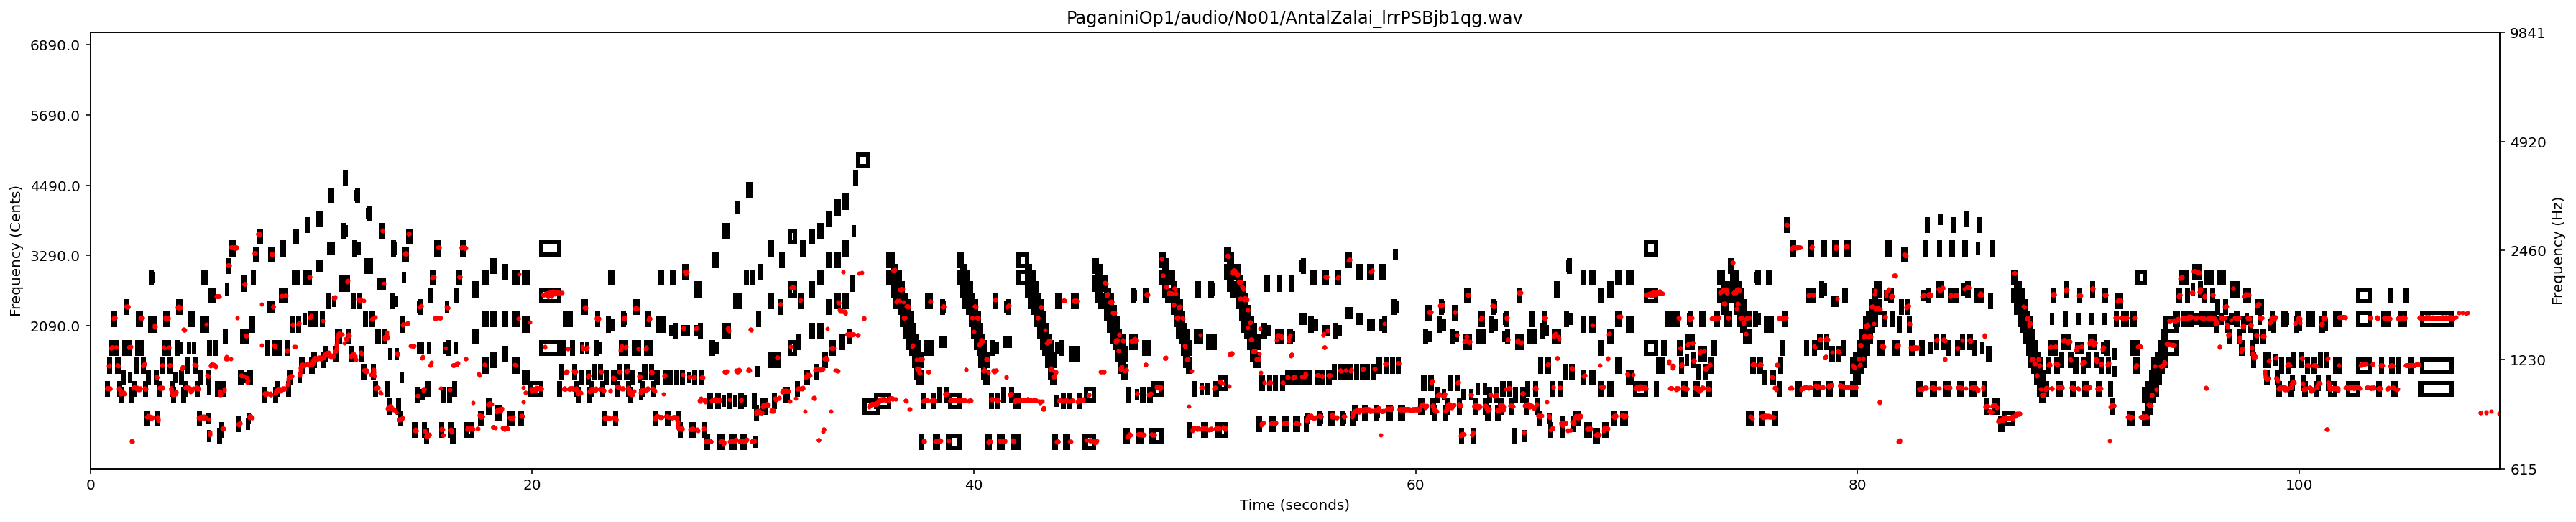

PaganiniOp1/audio/No01/IlyaKaler_1qpO5LFgHrM downloaded
........................................................................................

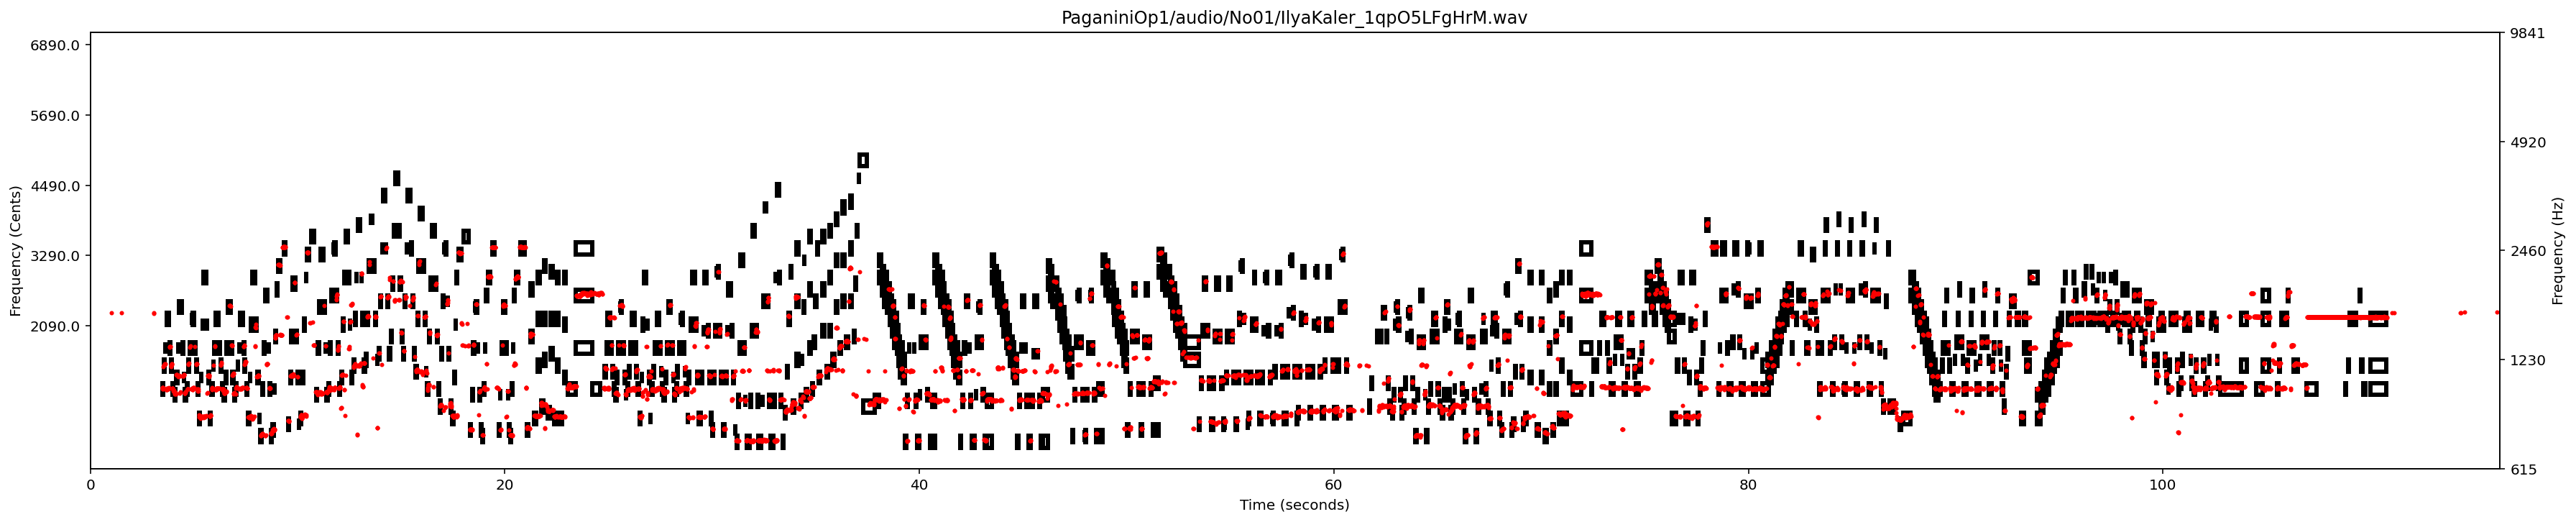

PaganiniOp1/audio/No01/InmoYang_MlTFL3LVylM downloaded
........................................................................................

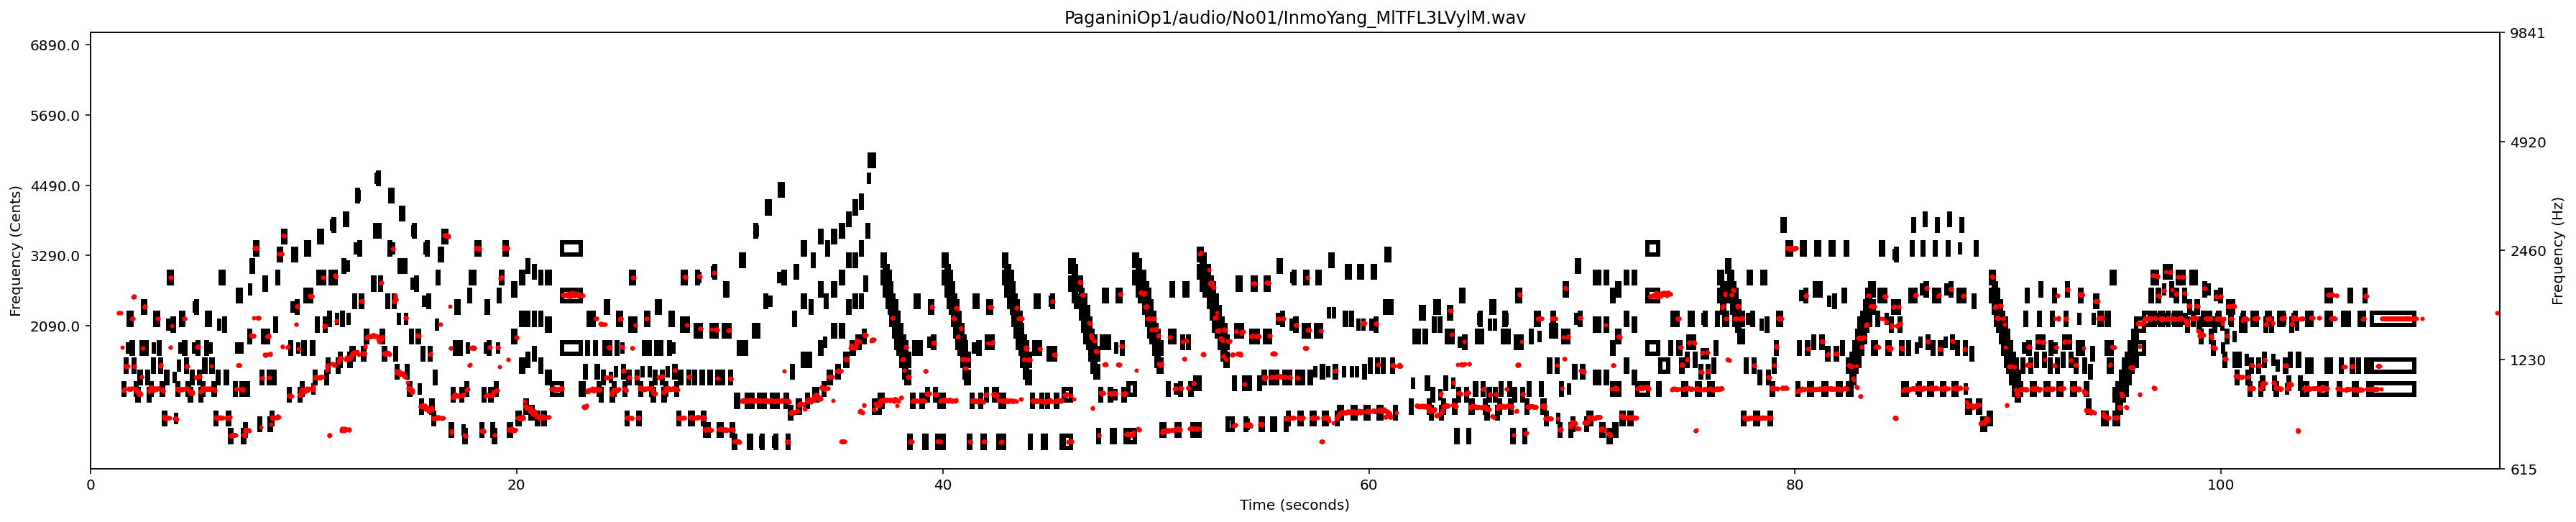

PaganiniOp1/audio/No01/ItzhakPerlman_8-L2ytj7_6g downloaded
........................................................................................

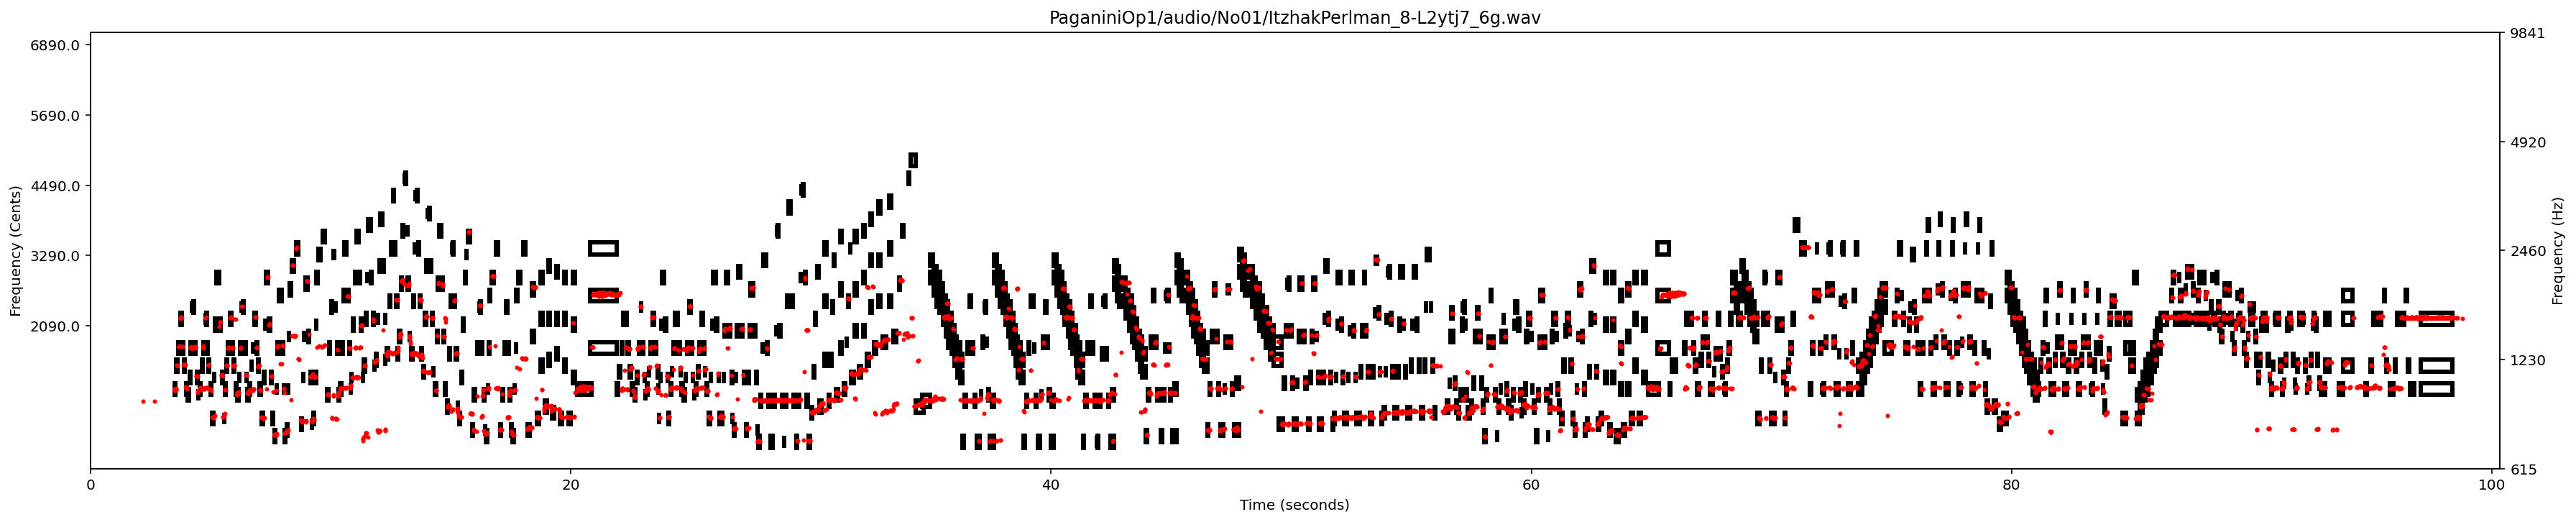

PaganiniOp1/audio/No01/JuliaFischer_b_S0mUMJ1fw downloaded


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


ERROR IN PaganiniOp1/audio/No01/JuliaFischer_b_S0mUMJ1fw
SKIPPING
PaganiniOp1/audio/No01/SalvatoreAccardo_tUKPPRN-Y00 downloaded
........................................................................................

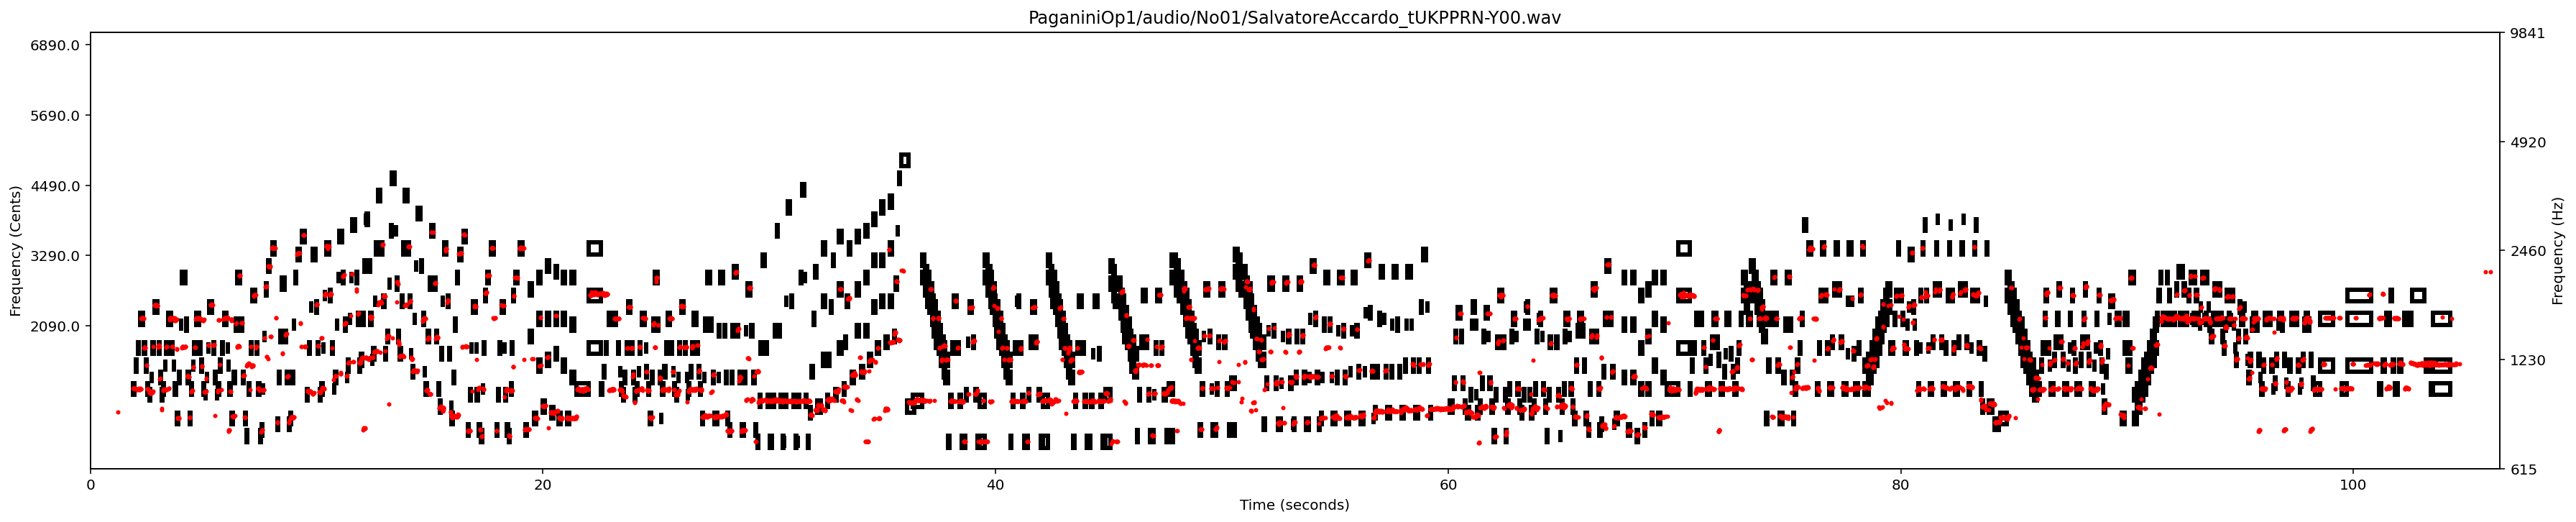

PaganiniOp1/audio/No02/AlicanSuner_ugVPJ1SdWB0 downloaded
........................................................................................

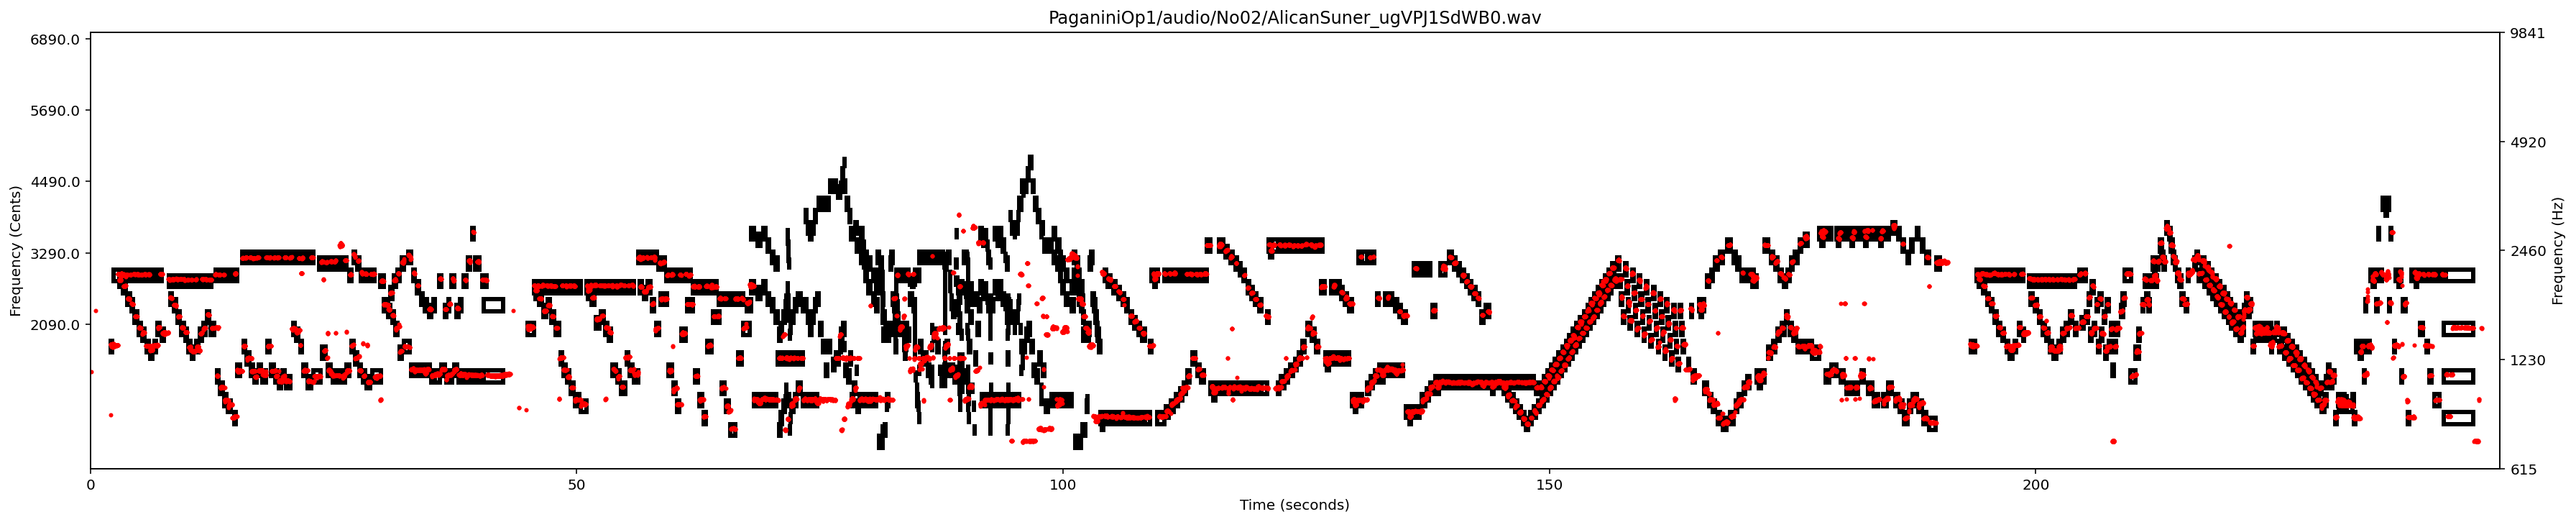

PaganiniOp1/audio/No02/AntalZalai_2qF7NIkxKM4 downloaded
........................................................................................

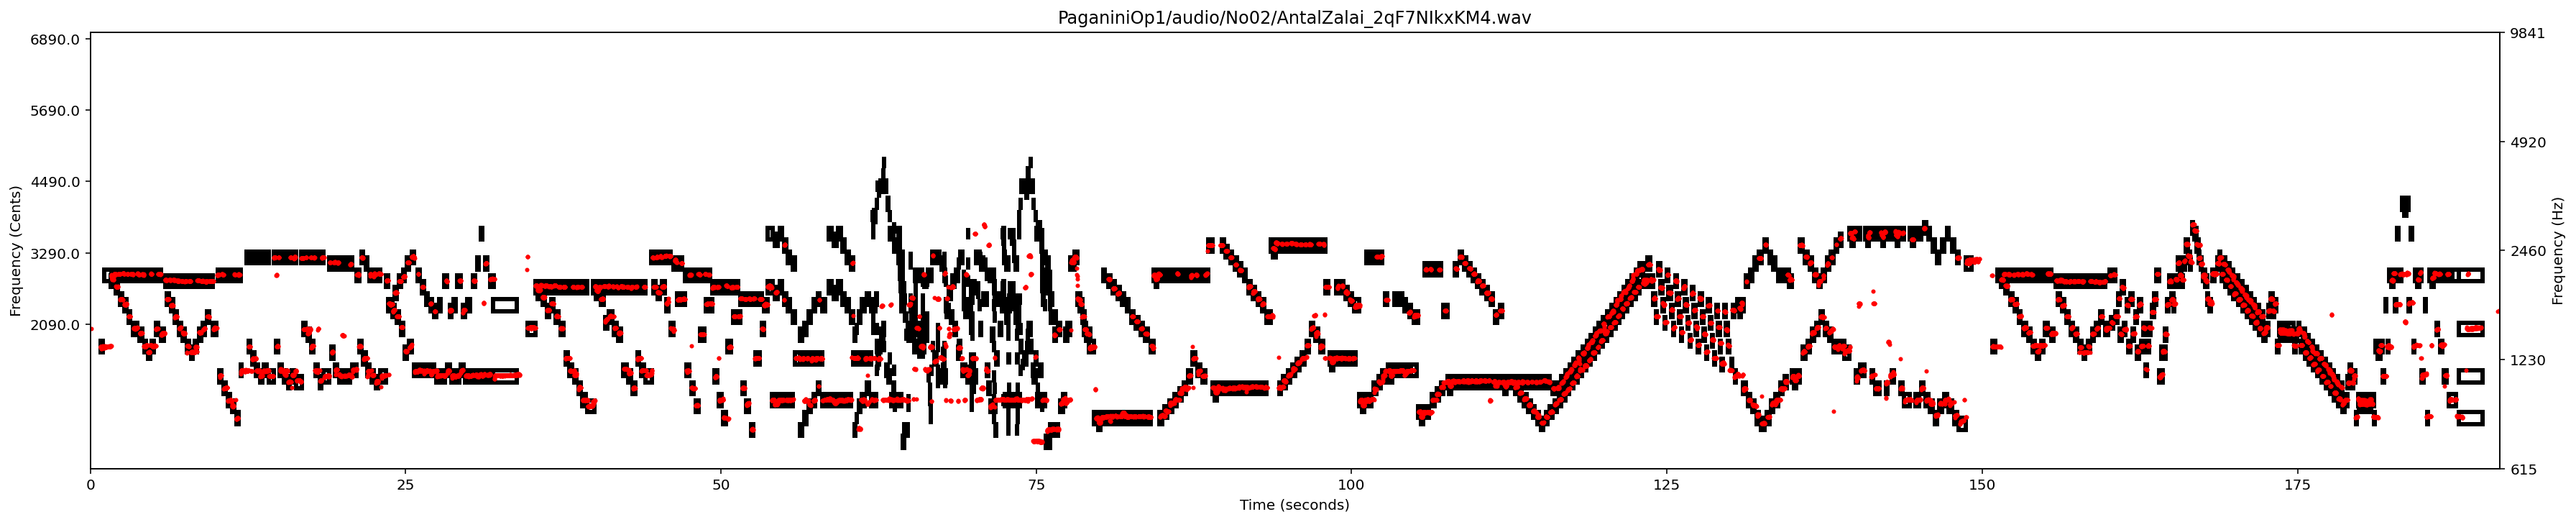

PaganiniOp1/audio/No02/IlyaKaler_O0agut0SaOc downloaded
........................................................................................

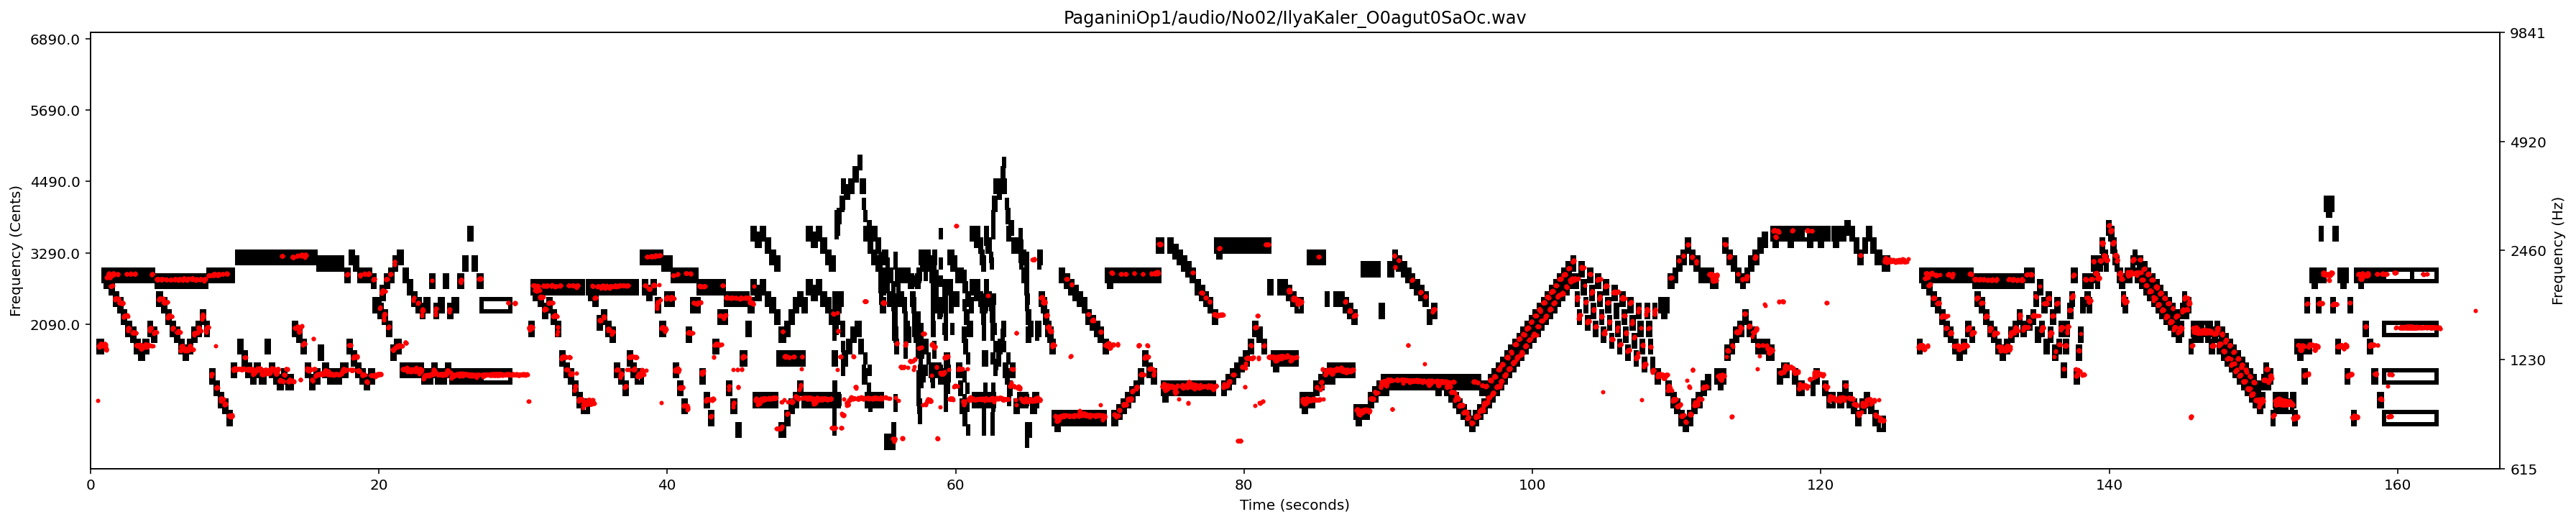

PaganiniOp1/audio/No02/InmoYang_p1rquj7M9tQ downloaded
........................................................................................

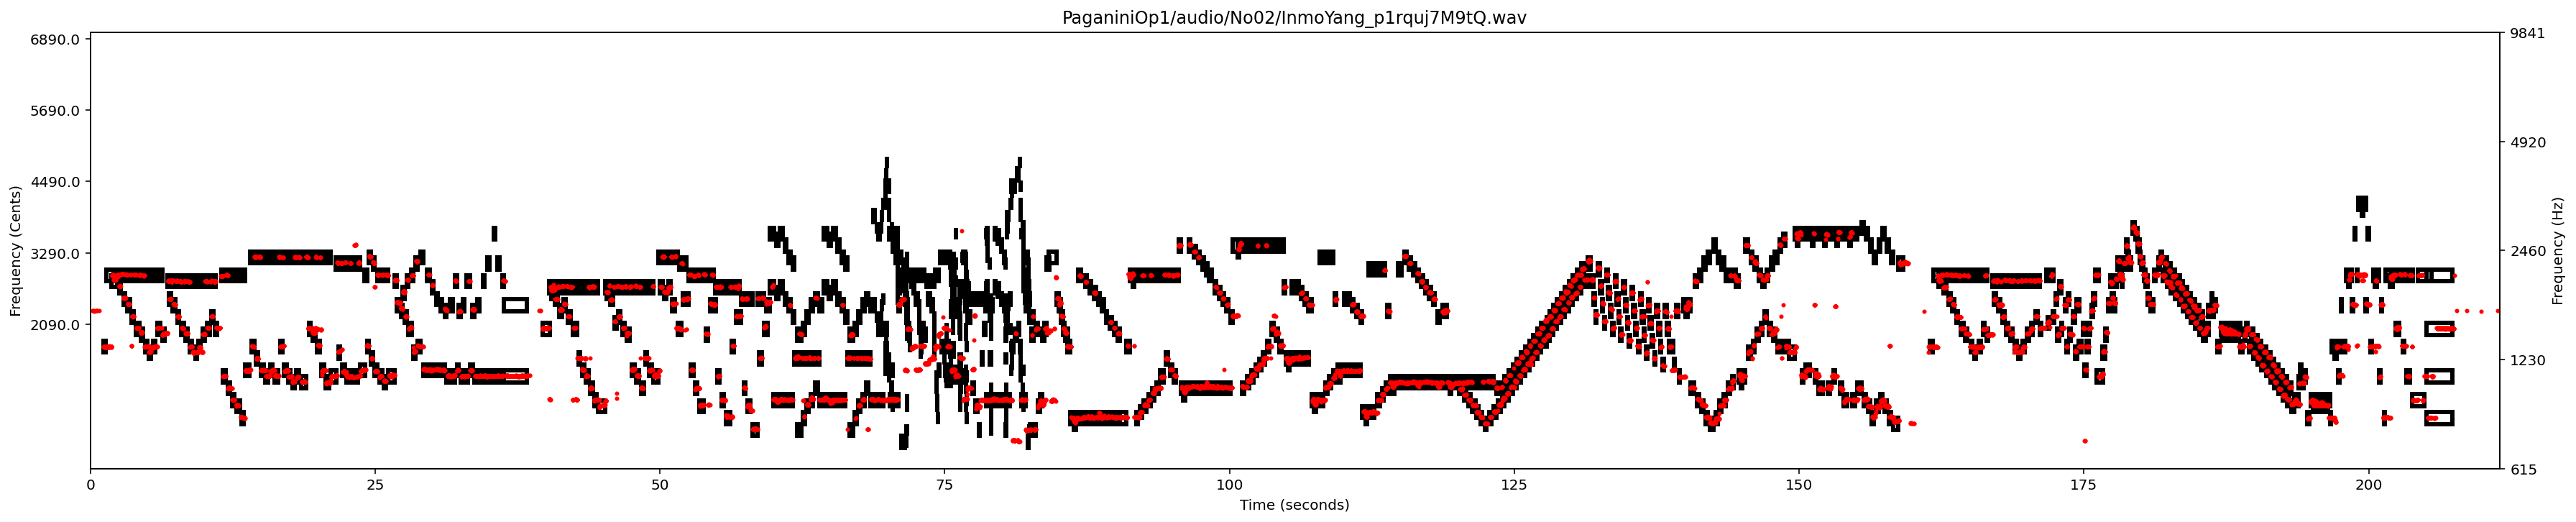

PaganiniOp1/audio/No02/ItzhakPerlman_KGSGm2QcZWM downloaded
........................................................................................

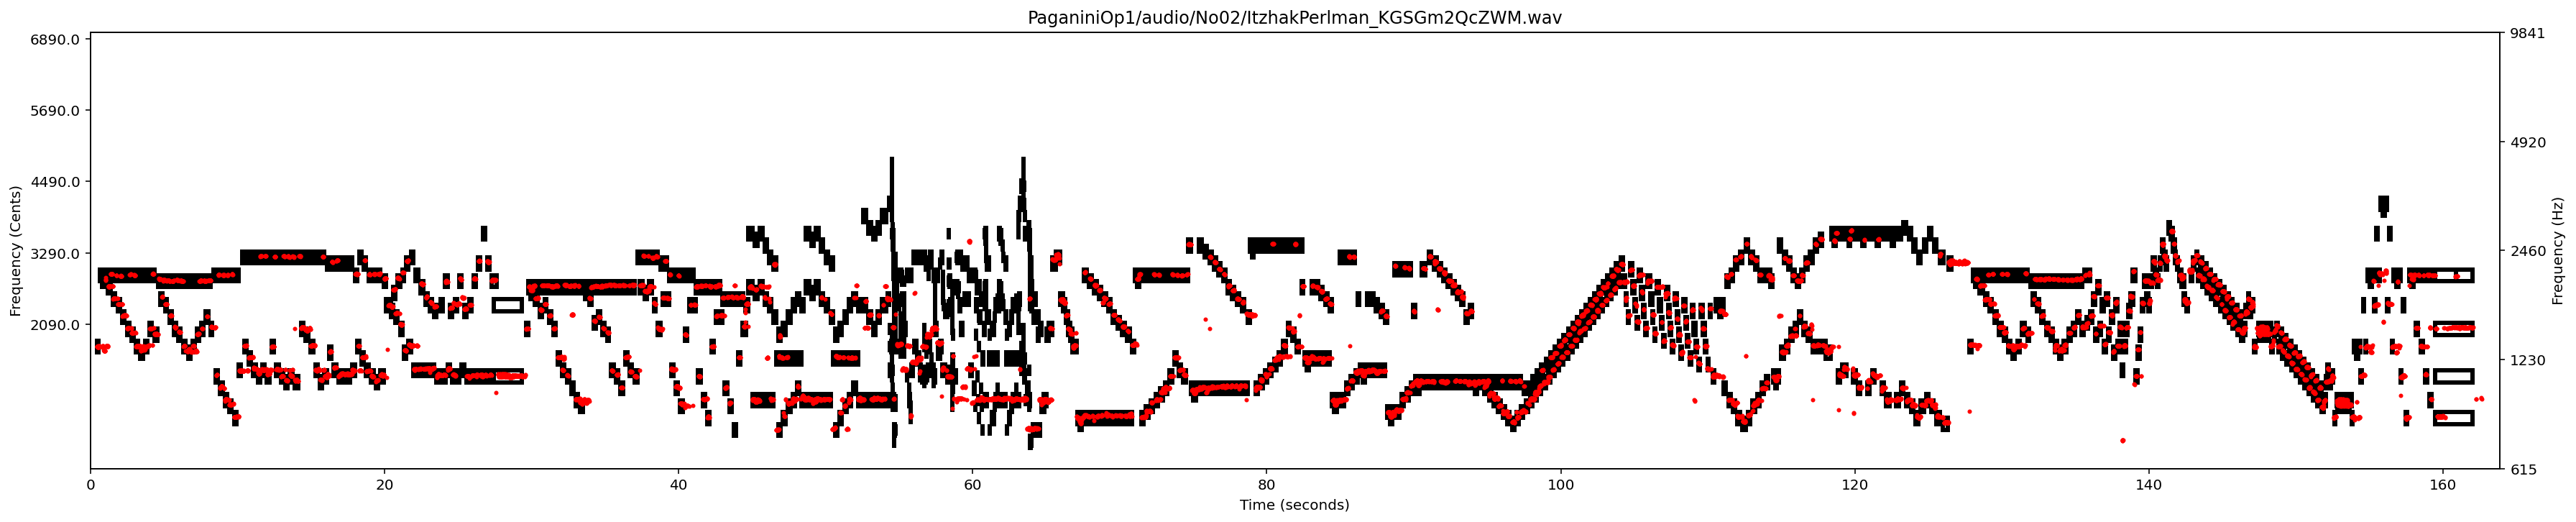

PaganiniOp1/audio/No02/JuliaFischer_PstR1bEiGZE downloaded


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


ERROR IN PaganiniOp1/audio/No02/JuliaFischer_PstR1bEiGZE
SKIPPING
PaganiniOp1/audio/No02/SalvatoreAccardo_G01Y2DRCkYE downloaded
........................................................................................

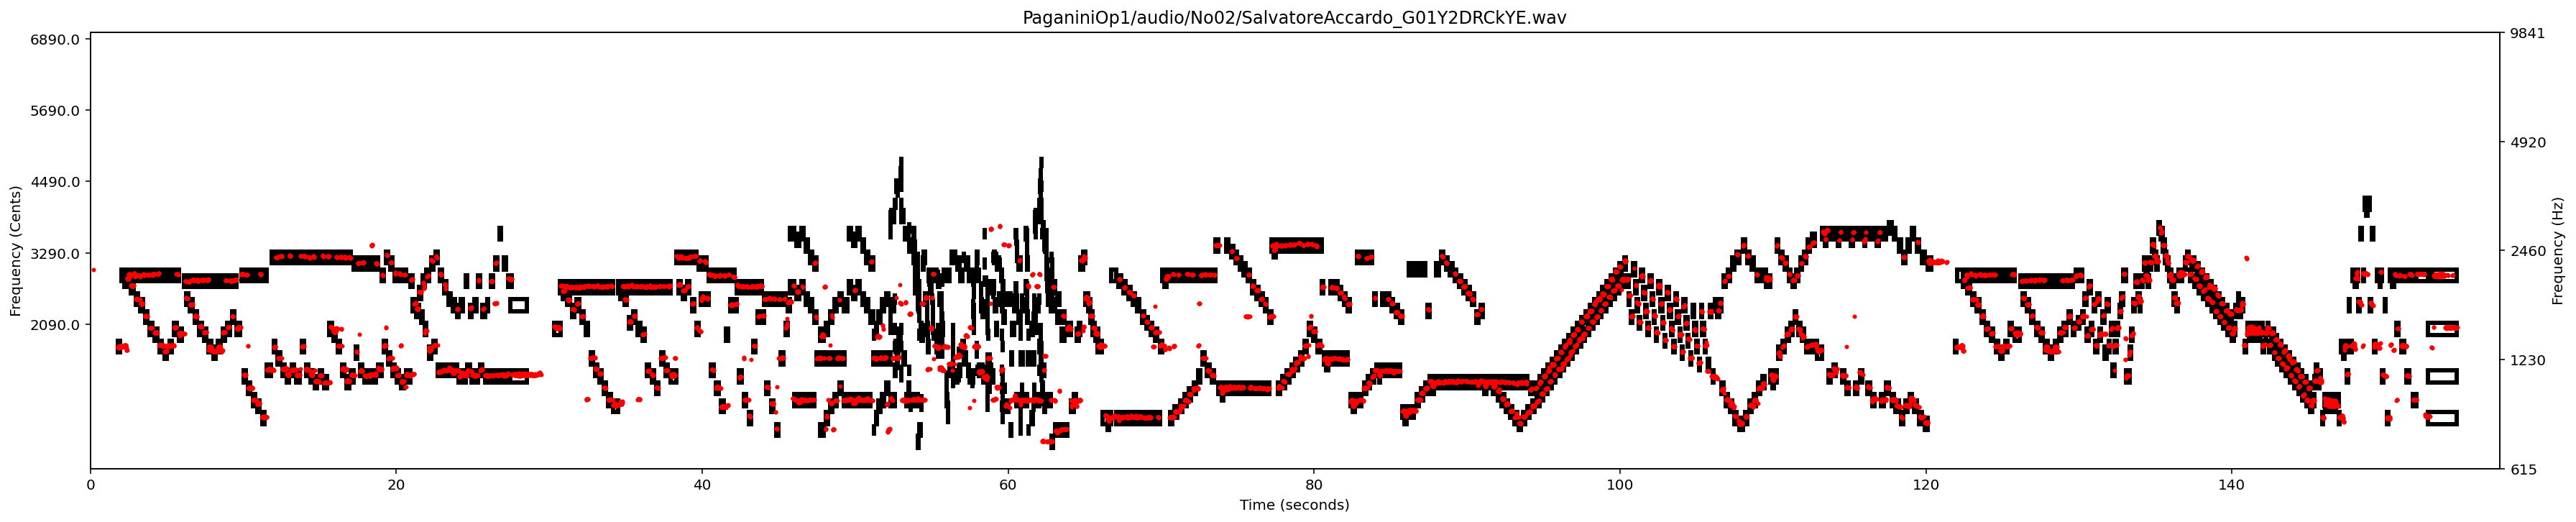

In [58]:
method_path = 'PaganiniOp1'
for no in ['No24', 'No01', 'No02']:
    midi_path = os.path.join(method_path, 'midi', no+'.mid')
    recordings = df[df['No'] == no]
    for i, row in recordings.iterrows():
        f0_path = os.path.join(f0_dir, row.f0Path)
        player, key = row.PlayerID, row.YouTubeKey
        audio_name = os.path.join(method_path, 'audio', no, player+'_'+key)
        !yt-dlp https://www.youtube.com/watch?v={key} -x --audio-format wav --audio-quality 0   -o "{audio_name}.%(ext)s"  &> /dev/null
        print(audio_name, 'downloaded')
        try:
            aligned_midi = align_midi(midi_path, audio_name+'.wav', f0_path, debug=True, offset=0, duration=None, f0_threshold=0.7)
            out_dir = os.path.join(method_path, 'aligned_midi', no)
            os.makedirs(out_dir, exist_ok=True)
            aligned_midi_path = os.path.join(method_path, 'aligned_midi', row.f0Path[:-6] + 'mid')  #.f0.csv
            aligned_midi.write(aligned_midi_path)
        except FileNotFoundError:
            print('ERROR IN', audio_name)
            print('SKIPPING')

In [59]:
import shutil
shutil.make_archive(os.path.join(method_path, 'aligned_midi'), 
                    'zip', os.path.join(method_path, 'aligned_midi'))

'/content/PaganiniOp1/aligned_midi.zip'

PaganiniOp1/audio/No01/IlyaKaler_1qpO5LFgHrM downloaded
........................................................................................

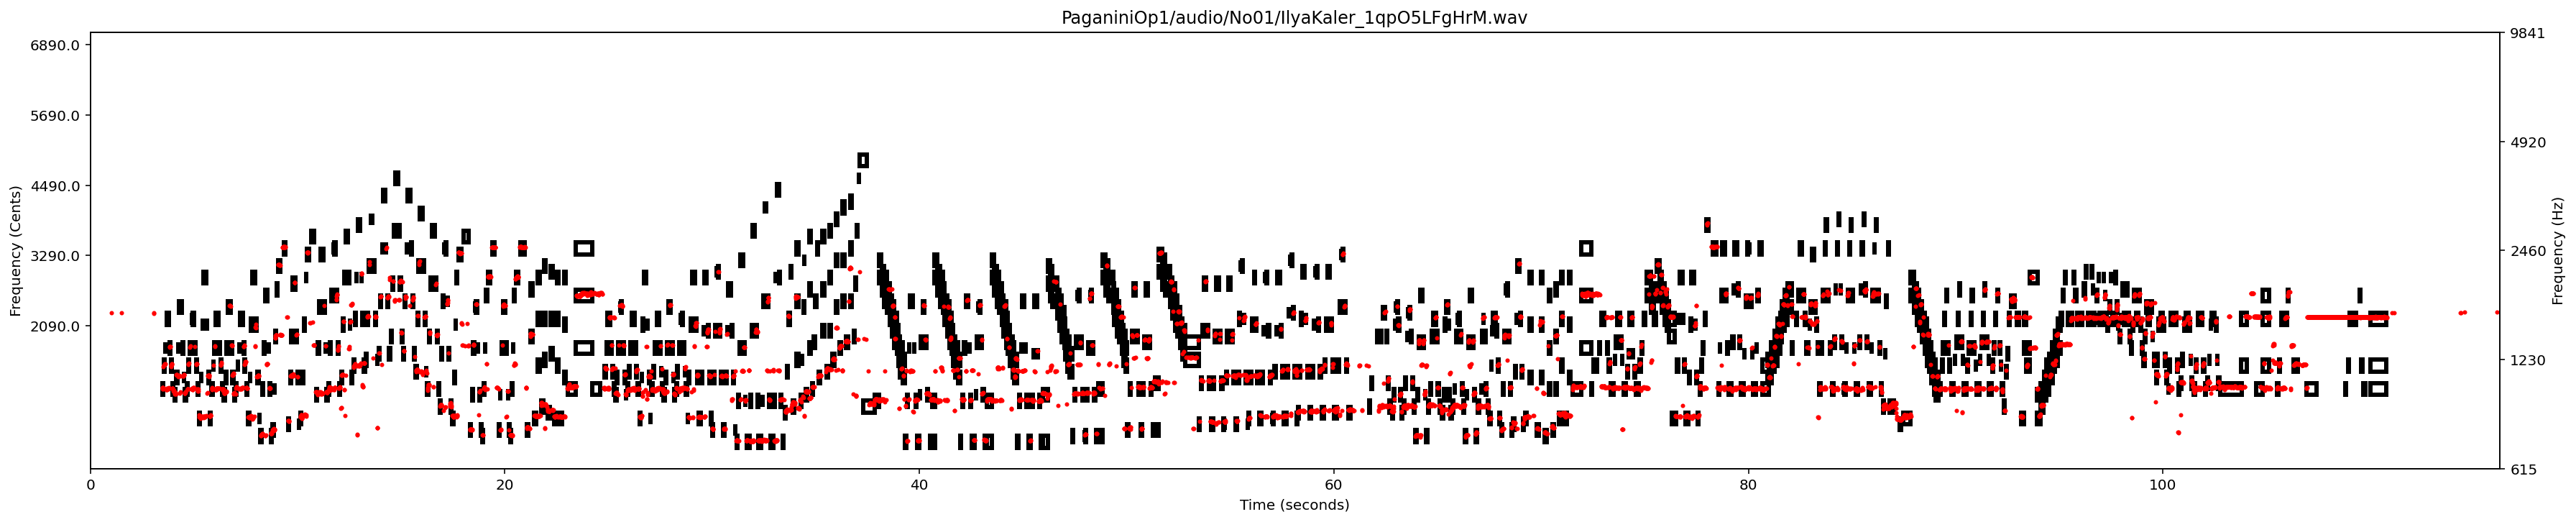

f0Path        No01/AlicanSuner_[lTsRFEpD6Jg]_0149.f0.csv
No                                                  No01
PlayerID                                     AlicanSuner
YouTubeKey                                   lTsRFEpD6Jg
Duration                                             149
Name: 0, dtype: object


AttributeError: ignored

In [53]:
no = 'No01'
midi_path = os.path.join("PaganiniOp1", 'midi', no+'.mid')
recordings = df[df['No'] == no]
row = recordings.iloc[2]
f0_path = os.path.join(f0_dir, row.f0Path)
player, key = row.PlayerID, row.YouTubeKey
audio_name = os.path.join('PaganiniOp1', 'audio', no, player+'_'+key)
!yt-dlp https://www.youtube.com/watch?v={key} -x --audio-format wav --audio-quality 0   -o "{audio_name}.%(ext)s"  &> /dev/null
print(audio_name, 'downloaded')
aligned_midi = align_midi(midi_path, audio_name+'.wav', f0_path, debug=True, offset=0, duration=None, f0_threshold=0.7)